In [1]:
import os

os.chdir("..")

os.getcwd()

'c:\\Users\\mquick\\Documents\\zeitgeist blog\\projects\\political_fragmentation'

In [50]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3 as sql
from utils import GiniCalculator

### Collect election results data

* Date range: 1832-2024
* [Source](https://electiondataarchive.org/data-and-documentation/clea-lower-chamber-elections-archive/)

In [3]:
clea_cols_map = {
    "id": "election_code",
    "yr": "year",
    "mn": "month",
    "cst": "constituency",
    "pty_n": "party",
    "pty": "party_code",
    "to1": "turnout",
    "pv1": "votes_total",
    "pvs1": "votes_pct"
} # https://electiondataarchive.org/data-and-documentation/variables/

In [4]:
query = f"""
SELECT
{", \n".join([f'{k} AS {v}' for k, v in clea_cols_map.items()])}
FROM clea
WHERE ctr_n = 'UK'
"""

In [13]:
print(query)


SELECT
id AS election_code, 
yr AS year, 
mn AS month, 
cst AS constituency, 
pty_n AS party, 
pty AS party_code, 
to1 AS turnout, 
pv1 AS votes_total, 
pvs1 AS votes_pct
FROM clea
WHERE ctr_n = 'UK'



In [5]:
with sql.connect("elections.db") as conn:
    result_df = pd.read_sql_query(query, conn)

In [6]:
print("Start:", result_df["year"].min())
print("End:", result_df["year"].max())

Start: 1832
End: 2019


In [8]:
for col in ["votes_pct", "votes_total"]:
    result_df.loc[result_df[col]<0, col] = None

In [11]:
calculator = GiniCalculator()

In [18]:
candidate_gini_df = calculator.gini_coeff_by_candidate(
    election_results_df=result_df,
    election_year_col="election_code",
    candidates_col="party"
    )

In [22]:
candidate_gini_df = candidate_gini_df.merge(result_df[["election_code", "year", "month"]].drop_duplicates(),
                                            on="election_code",
                                            how="inner")

In [41]:
candidate_gini_df["election_date"] = candidate_gini_df.apply(
    lambda x: datetime(
        year=x["year"], 
        month=x["month"], 
        day=1).strftime("%Y, %b"), 
    axis=1)

In [44]:
candidate_gini_df["party_election"] = candidate_gini_df.apply(lambda x: f"{x['party']}, {x['election_date']}", axis=1)

In [45]:
candidate_gini_df["rank"] = candidate_gini_df.groupby("election_date", as_index=False)["votes_total"].rank(ascending=False)

In [48]:
candidate_gini_df\
    .sort_values(["year", "month"], ascending=False)\
    .loc[candidate_gini_df["rank"]==1, ["election_date", "party"]]\
    .head(10)

,election_date,party
1359,"2019, Dec",Conservative
1285,"2017, Jun",Conservative
1152,"2015, May",Conservative
1015,"2010, May",Conservative
903,"2005, May",Labour Party
823,"2001, Jun",Labour Party
676,"1997, May",Labour Party
484,"1992, Apr",Conservative
461,"1987, Jun",Conservative
424,"1983, Jun",Conservative


In [61]:
candidate_gini_df["party_clean"] = candidate_gini_df["party"].apply(
    lambda x: "conservative" 
    if "Conservative" in x
    else "labour" if "Labour" in x
    else "liberal" if "Liberal" in x
    else "ukip" if "UK Indep" in x
    else None)

<Axes: xlabel='gini_coeff', ylabel='party_election'>

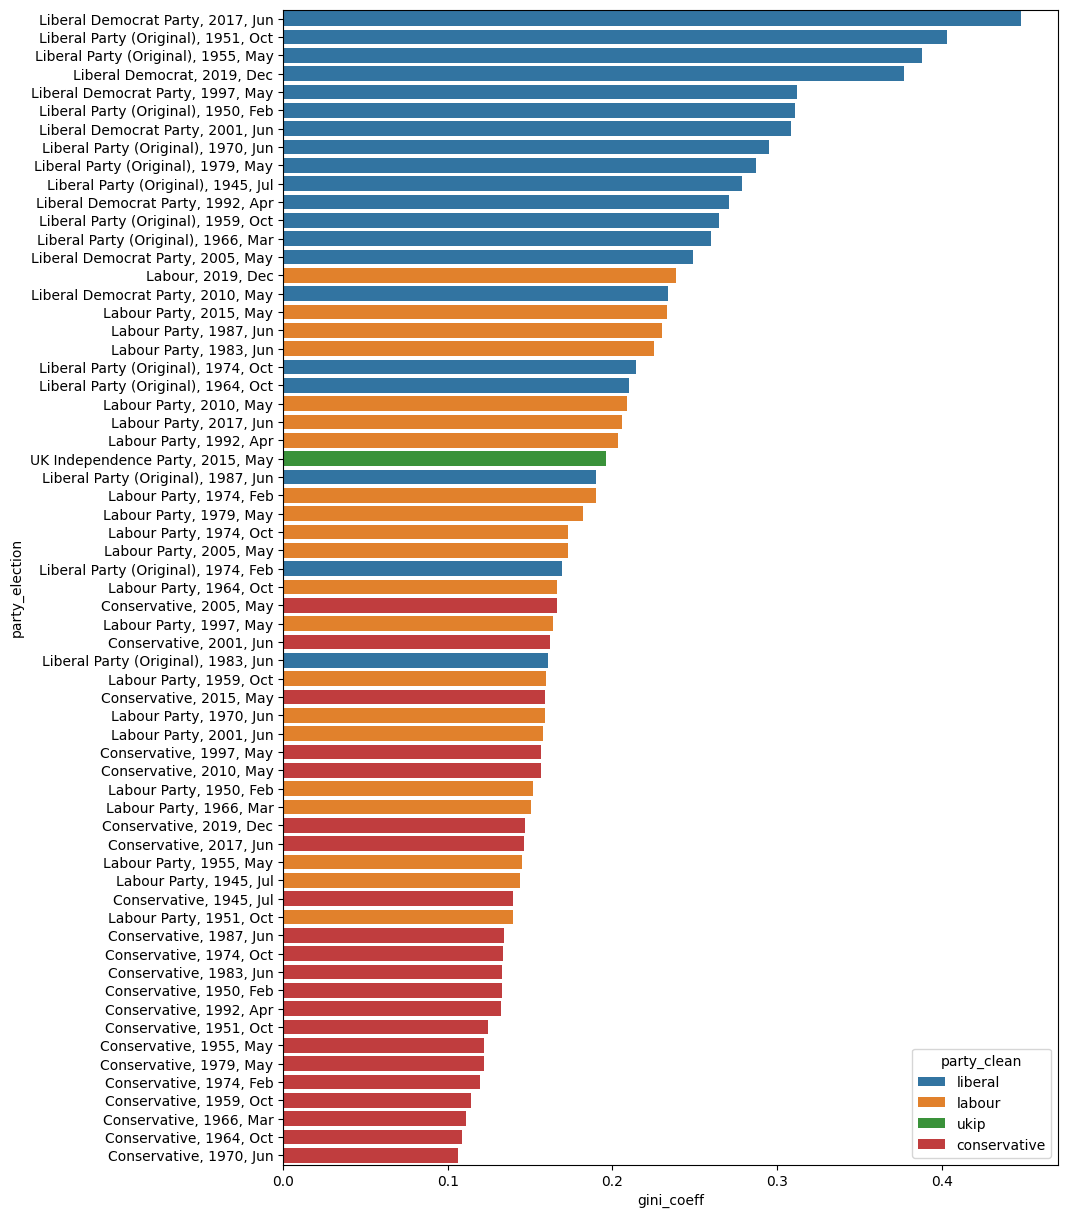

In [63]:
fig, ax = plt.subplots(figsize=(10, 15))

sns.barplot(
    data=candidate_gini_df[
        (candidate_gini_df["rank"]<=3) & (candidate_gini_df["year"]>=1945)
        ].sort_values("gini_coeff", ascending=False),
    x="gini_coeff",
    y="party_election",
    hue="party_clean",
)

In [67]:
candidate_gini_df.columns

Index(['election_code', 'party', 'gini_coeff', 'votes_total', 'year', 'month',
       'election_date', 'party_election', 'rank', 'party_clean'],
      dtype='object')

In [94]:
candidate_gini_df.loc[
    (candidate_gini_df["year"]>=1997) 
    & (candidate_gini_df["party"].isin(["Labour Party", "Labour"])),
    ["year", "gini_coeff"]
    ]

,year,gini_coeff
676,1997,0.164095
823,2001,0.157906
903,2005,0.172881
1018,2010,0.208688
1153,2015,0.233216
1284,2017,0.205856
1360,2019,0.238477


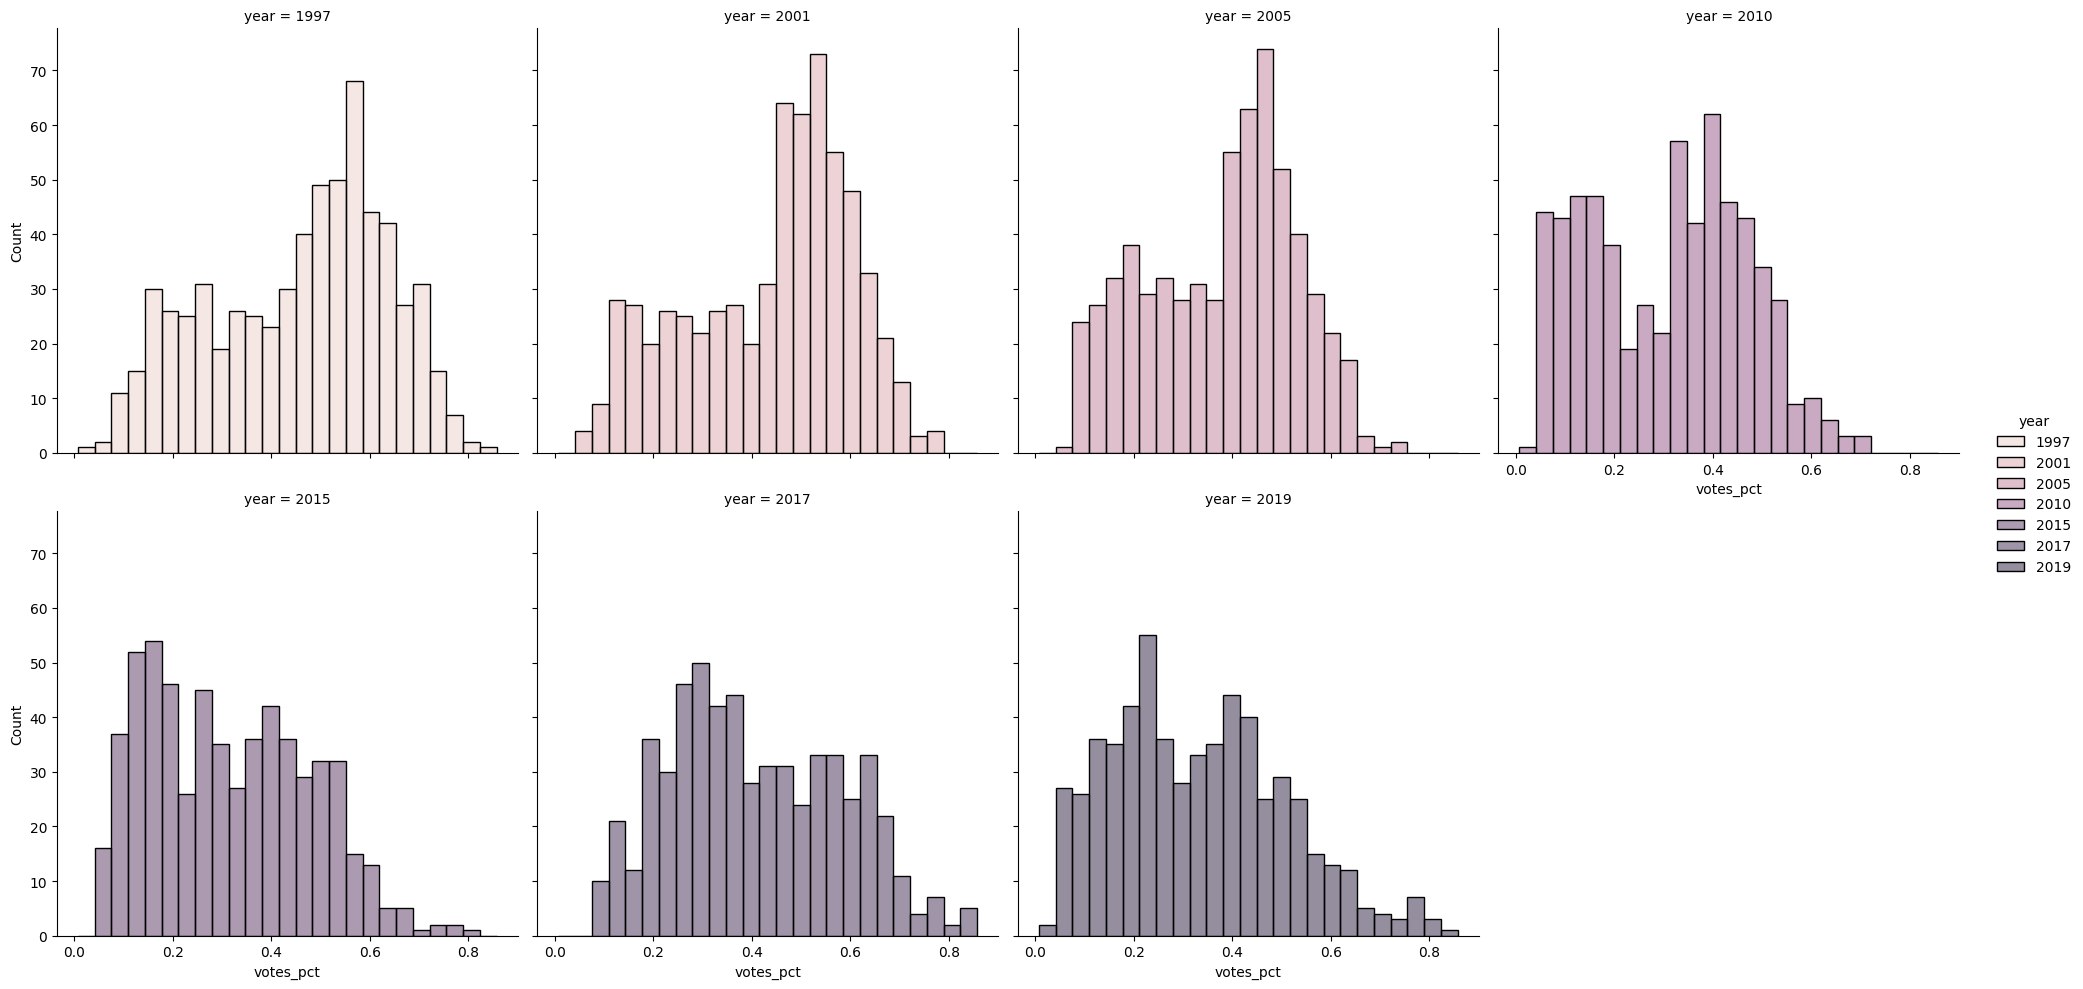

In [92]:
sns.displot(data=result_df[
    (result_df["year"]>=1997) 
    & (result_df["party"].isin(["Labour Party", "Labour"]))
    ],
            kind="hist", col_wrap=4, col="year", x="votes_pct", hue="year")

In [64]:
gini_by_election = calculator.gini_coeff_by_election(
    candidate_gini_scores_df=candidate_gini_df,
    group_by_cols=["election_date"]
    )

In [83]:
candidate_gini_df.loc[(candidate_gini_df["rank"]<=3) & (candidate_gini_df["year"]>=2010), 
                      ["year", "party", "gini_coeff"]].sort_values("year", ascending=False)

,year,party,gini_coeff
1360,2019,Labour,0.238477
1356,2019,Liberal Democrat,0.377072
1359,2019,Conservative,0.146950
1284,2017,Labour Party,0.205856
1283,2017,Liberal Democrat Party,0.448373
1285,2017,Conservative,0.146152
1152,2015,Conservative,0.158966
1146,2015,UK Independence Party,0.195912
1153,2015,Labour Party,0.233216
1018,2010,Labour Party,0.208688


<Axes: xlabel='election_date'>

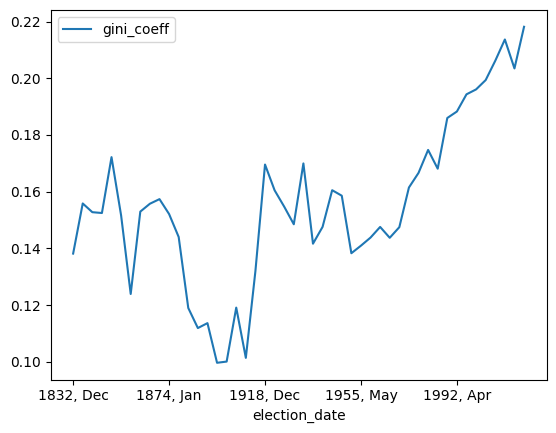

In [72]:
gini_by_election.plot.line(x="election_date", y="gini_coeff")